# Functional approach to simulating a game of Tennis!

Suppose you’re playing a match at the U.S. Open, and you’re slightly better than the competition: your chances of winning any given point are exactly 55 percent. (Yes, most players are more likely to win the points they serve, but we’re simplifying things a bit.) What are your chances of winning a three-set match, as played by the women, or a five-set match, as played by the men? And what are your chances of winning the whole tournament (seven consecutive matches)?

In [2]:
import collections
import functools
import numpy as np
import toolz
import toolz.curried
from typing import Callable, Iterator

# Common functions for the simulation

The main method here is "step". This function is a generator that keeps generating the subsequent score. The subseqent score is just an increment of the current score for the winner of the play. The play is a function that generates the winner. This function (step) is an infinite generator that does not know the rules of the game of tennis. 

The intelligence regarding the rules of the game are introduced later as filtering functions. Basically, we will filter all the states generated by the step function that satisfy the conditions for the ending of a game/ set/ match/ tournament - The first of such states is the end of that particular game/ set/ match/ tournament. 

Therefore, our plan of action is as follows:
1. play_game: Generate infinite sequence of game state by simulating a series of points -> Filter for states that end a game -> Return game winner
2. play_set: Generate infinite sequence of set state by simulating a series of games (from play_game) -> Filter for states that end a set -> Return a set winner
3. play_match: Generate infinite sequence of match states by simulating a series of sets (from play_get) -> Filter for states that end a match -> Return a match winner.
4. A Tournament is simulated by playing 7 matches (grand slam) and you win if you win all the 7 matches.


In [3]:
Score = collections.namedtuple("score", ["you", "opponent"])
def step(play: Callable[[], int]) -> Iterator[Score]:
    """Progresses the game by one step (point/ game/ set).
    
    Args:
      play: A function that progresses the game by one step.(Returns +1 / -1)
      
    Returns:
      Iterator of scores.
    """
    def get_next_score(score: Score, winner: int) -> Score:
        score_you, score_other = score
        if winner == 1:
            score_you += 1
        else:
            score_other += 1
        return Score(score_you, score_other)
    
    score = Score(0, 0)
    while True:
        yield score
        score = get_next_score(score, play()) 

def get_winner(score:Score) -> int:
    """Fetches winner of the game.
      Returns: 
       +1 if you win game, -1 if opponent wins the game
    """
    score_you, score_other = score
    return 1 if score_you > score_other else -1

# Determine the winner

## Determine the end of a game
Note: We treat the tiebreaker as a game to 7, while a regular game is a game to 4

In [4]:
def is_game_over(score: Score, cut_off_point) -> bool:
    """Returns True if we have a winner.
    Args:
      score: The score of the game
      cut_off_point: Minimum points needed to win the game
    
    Returns:
      True if game is over else False.
    """
    score_you, score_other = score
    def check_score(score1, score2):
        return (score1 - score2 >= 2) and (score1 >= cut_off_point) 

    if score_you > score_other:
        if check_score(score_you, score_other):
            return True
    else:
        if check_score(score_other, score_you):
            return True
    return False 

# TESTS
assert False == is_game_over((0, 1), 4)
assert True == is_game_over((2, 4), 4) # 30 - Game
assert True == is_game_over((4, 1), 4)
assert False == is_game_over((5, 5), 4)
assert False == is_game_over((3, 6), 7)
assert False == is_game_over((7, 7,), 7)
assert True == is_game_over((9, 7), 7)

## Determine the end of a set

In [5]:
def is_set_over(score: Score) -> bool:
    """True if the set is over.
    """
    score_you, score_other = score

    if score_you <= 5 and score_other <= 5:
        return False

    if score_you == 6 and score_other == 6:
        return True 

    if score_you >= 6 and score_you - score_other >= 2:
        return True

    if score_other >=6 and score_other - score_you >= 2:
        return True
    
    return False
    
# Tests
assert True == is_set_over((6, 3))
assert True == is_set_over((6, 4))
assert True == is_set_over((4, 6))
assert True == is_set_over((0, 6))
assert False == is_set_over((5, 6))
assert False == is_set_over((6, 5))
assert True == is_set_over((6, 6))
assert True == is_set_over((7, 5))
assert True == is_set_over((5, 7))

##  Determine the end of a match

In [6]:
def is_match_over(score: Score, num_sets) -> bool:
    """Tells if we have finished a match."""
    if sum(score) >= num_sets:
        return True
    else:
        score_you, score_other = score
        if score_you > score_other:
            if score_you >= num_sets // 2 + 1:
                return True
        else:
            if score_other >= num_sets // 2 + 1:
                return True
    return False

# Tests
assert True == is_match_over((3,2), 5)
assert True == is_match_over((2,3), 5)
assert True == is_match_over((2, 0), 3)
assert True == is_match_over((0, 3), 5)
assert False == is_match_over((2, 0), 5)
assert False == is_match_over((2, 1), 5)
assert False == is_match_over((1, 2), 5)
assert True == is_match_over((1, 3), 5)

# Play a game of tennis!

In [7]:
def play_point(prob: float) -> int:
    """Plays a point.
    
    Args:
      prob: probability of winning the point.
    
    Returns:
      1 if you win the point, -1 otherwise
    """
    return 1 if np.random.random() <= prob else -1

def play_game(prob: float, cut_off_point: int) -> int:
    """Plays a game of tennis.
    
    Args:
     prob: (float) Probability that you win the point (0 < prob < 1)
     cut_off_point: The minimum number of points to win to win the game
    Returns:
      1 if you win , -1 if opponent wins
    """
    assert 0 < prob < 1
    play = functools.partial(play_point, prob=prob)
    predicate_game_over = functools.partial(is_game_over, cut_off_point=cut_off_point)
    return toolz.pipe(step(play),
                      toolz.curried.filter(predicate_game_over),
                      next,
                      get_winner)

def play_set(prob: float) -> int:
    """Plays a set of tennis.
      Args:
        prob: probability of winning a point
      Returns:
        1 if you win the set, -1 if opponent wins the set.
    """     
    def play_tiebraker_if_needed(score:Score) -> Score:
        score_you, score_other = score
        if score_you == 6 and score_other == 6:
            winner = play_game(prob=prob, cut_off_point=7)
            if winner == 1:
                score_you += 1
            else:
                score_other += 1
        return Score(score_you, score_other)
    
    play = functools.partial(play_game, prob=prob, cut_off_point=4)
    return toolz.pipe(step(play), 
                      toolz.curried.filter(is_set_over),
                      next,
                      play_tiebraker_if_needed,
                      get_winner)

def play_match(prob: float, num_sets: int) -> int:
    """Plays a match of tennis.
    
    Args:
      prob: probability of you winning a point
      num_sets: Total number of sets in the match
    
    Returns:
      +1 if you Win, -1 if opponent wins
    """
    play = functools.partial(play_set, prob=prob)
    predicate_match_over = functools.partial(is_match_over, num_sets=num_sets)
    return toolz.pipe(step(play),
                      toolz.curried.filter(predicate_match_over),
                      next,
                      get_winner)

def play_tournament(prob: float, num_matches: int, num_sets_per_match:int) -> bool:
    """Returns True if you win the tournament.
    
    Args:
      prob: probability of winning a point
      num_matches: number of matches in the tournament
      num_sets_per_match: number of sets per match
      
    Returns:
      True if you win the tournament
    """
    def match_result():
        return True if play_match(prob, num_sets_per_match) == 1 else False
    
    return all([match_result() for _ in range(num_matches)])

# Find the probability of winning using simulation

In [8]:
def win_probability(prob: float, num_matches: int, num_sets_per_match:int, n_sim:int=10000) -> float:
    """Returns the win probability of winning the tournament.
    
    Args:
      prob: probability of winning a point
      num_matches: number of matches in the tournament
      num_sets_per_match: number of sets per match
      n_sim: number of simulations (Default=10000)
    Returns:
      win probability
    """
    return sum((play_tournament(prob, num_matches, num_sets_per_match) for _ in range(n_sim))) / n_sim

# Women's tournament

In [9]:
wp = np.mean(list(win_probability(0.55, 1, 3, 10000) for _ in range(10)))
print("Women's match win probability is ~ {0:.2f}%".format(wp * 100))
print("Women's tournament win probability is ~ {0:.2f}%".format((wp **7) * 100))

wp = np.mean(list(win_probability(0.55, 7, 3, 1000) for _ in range(10)))
print("Women's tournament win probability is ~ {0:.2f}%".format(wp * 100))

Women's match win probability is ~ 90.46%
Women's tournament win probability is ~ 49.57%
Women's tournament win probability is ~ 51.80%


# Men's tournament

In [10]:
wp = np.mean(list(win_probability(0.55, 1, 5, 10000) for _ in range(1)))
print("Men's match win probability is ~ {0:.2f}%".format(wp * 100))
print("Men's tournament win probability is ~ {0:.2f}%".format((wp **7) * 100))

wp = np.mean(list(win_probability(0.55, 7, 5, 10000) for _ in range(10)))
print("Men's tournament win probability is ~ {0:.2f}%".format(wp * 100))

Men's match win probability is ~ 95.37%
Men's tournament win probability is ~ 71.76%


# How does the probability change according to skill

In [11]:
def plot_skills(skills, matches, sets):
    match_wps = [win_probability(skill, 1, sets, 1000) for skill in skills]
    tourey_wps = [win_probability(skill, matches, sets, 1000) for skill in skills]
    
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(211)
    ax.plot([s * 100 for s in skills], [w * 100 for w in match_wps])
    ax.set_ylabel('Match Win Probability')
    ax.set_xlabel('Point Win Probability')
    
    ax = fig.add_subplot(212)
    ax.plot([s * 100 for s in skills], [w * 100 for w in tourey_wps])
    ax.set_ylabel('Tournament Win Probability')
    ax.set_xlabel('Point Win Probability')
    
    plt.suptitle('{0} sets/ {1} matches in tournament'.format(sets, matches))
    

In [12]:
skills = [0.1, 0.2, 0.3, 0.35, 0.40, 0.45, 0.5, 0.55, 0.6, 0.65, 0.70, 0.80, 0.90]
plot_skills(skills, 7, 5)

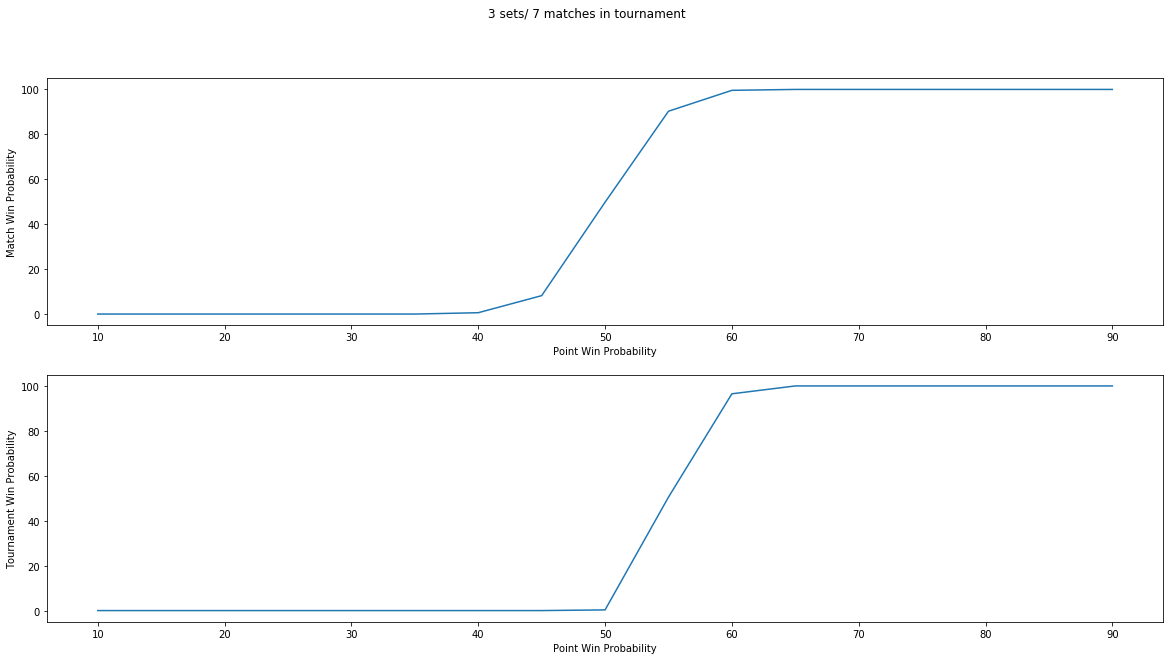

In [13]:
plot_skills(skills, 7, 3)